In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
#from keras.preprocessing import image
from keras.utils import to_categorical
import shutil
import cv2
import matplotlib.pyplot as plt
import math
import random
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [27]:


def select_contour_with_least_bright_colors(contours, img_rgb):
    # Filtrar contornos com base em sua área
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 100000]
    
    # Se não houver contornos após o filtro, retorne None
    if not filtered_contours:
        return None
    
    # Calcular a proporção de cores claras para cada contorno
    brightness_scores = []
    for contour in filtered_contours:
        mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        
        # Obter os pixels da imagem original que estão dentro do contorno
        pixels_inside_contour = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
        
        # Calcular a média da soma dos valores dos canais R, G e B
        mean_brightness = np.mean(pixels_inside_contour[pixels_inside_contour > 0])
        brightness_scores.append(mean_brightness)
    
    # Selecionar o contorno com a menor proporção de cores claras
    desired_contour = filtered_contours[np.argmin(brightness_scores)]
    
    return desired_contour


def process_image(img_entry):  
    
    # Aplicar um blur
    blurred = img_entry  # Mantendo a imagem original sem blur

    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
           
    # Threshold adaptativo    
    _, thresh = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)

    # Operações de opening e closing para melhorar contornos e diminuir ruídos
    kernel = np.ones((5,5),np.uint8)
    result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    inverted_image = cv2.bitwise_not(result)    
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Selecionar no máximo 10 objetos com maiores áreas
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] 

    # Selecionar o contorno com a menor proporção de cores claras
    selected_contour = select_contour_with_least_bright_colors(contours, img_entry)

    M = cv2.moments(selected_contour)
    if M['mu02'] != 0:
        fish_angle = 0.5 * math.atan2(2 * M['mu11'], (M['mu20'] - M['mu02']))
        fish_angle = math.degrees(fish_angle)  # converter para graus
    else:
        fish_angle = 0
    
    # Criar uma máscara
    mask = np.zeros_like(gray)   
    cv2.drawContours(mask, [selected_contour], -1, (255), thickness=cv2.FILLED)

    # Aplicar a máscara na imagem original
    masked_img = cv2.bitwise_and(img_entry, img_entry, mask=mask)

    # Criar uma imagem totalmente branca do mesmo tamanho que a imagem original
    white_img = np.ones_like(img_entry) * 255

    # Inverter a máscara
    inverse_mask = cv2.bitwise_not(mask)

    # Aplicar a máscara invertida à imagem branca
    white_background = cv2.bitwise_and(white_img, white_img, mask=inverse_mask)

    # Combinar a imagem de fundo branco com a imagem mascarada
    final_img = cv2.add(masked_img, white_background)

    # Converter para RGB
    image_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    return image_rgb, fish_angle

In [28]:
# Ler o arquivo CSV
df = pd.read_csv(r"C:\Users\marcio\Documents\tulane_filtered_multimedia.csv")

# Criar um dicionário mapeando ARKID para scientificName
arkid_to_class = dict(zip(df['ARKID'], df['scientificName']))

# Diretório das imagens
image_dir = "C:/Users/marcio/Documents/tulane_images"  # Substitua pelo caminho da sua pasta de imagens

# Iterar sobre os arquivos na pasta de imagens
for filename in os.listdir(image_dir):
    # Obter o nome do arquivo sem extensão
    base_name = os.path.splitext(filename)[0]
    
    # Obter a classe usando o dicionário
    image_class = arkid_to_class.get(base_name)
    
    if image_class:
        # Caminho da pasta da classe
        class_dir = os.path.join(image_dir, image_class)
        
        # Se a pasta da classe não existir, criar
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        # Mover a imagem para a pasta da classe
        src_path = os.path.join(image_dir, filename)
        dst_path = os.path.join(class_dir, filename)
        shutil.move(src_path, dst_path)

In [29]:
def load_images_from_folder(folder):
    images = []
    labels = []
    label_dict = {}
    current_label = 0
    
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                
                img = cv2.imread(os.path.join(subdir_path, filename))

                #primeiro deleta régua e tag
                img, fish_angle = process_image(img)
                
                #redimensiona a imagem
                img = cv2.resize(img, (128, 128)) #128
                
                #rotaciona  a imagem para deixar o peixe reto
                (h, w) = img.shape[:2]
                center = (w // 2, h // 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, fish_angle, 1)
                rotated = cv2.warpAffine(img, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))                 
                                
                #normaliza a imagem para [0-1]
                img_norm = rotated / 255.0

                images.append(img_norm)   
                             
                # Atribuir ou obter rótulo
                if subdir not in label_dict:
                    label_dict[subdir] = current_label
                    current_label += 1
                labels.append(label_dict[subdir])
                    
    return np.array(images), np.array(labels), label_dict

In [30]:
folder_path = "C:/Users/marcio/Documents/tulane_images/"  
images, labels, label_dict = load_images_from_folder(folder_path)

In [31]:
label_dict

{'Cyprinus carpio': 0,
 'Esox americanus': 1,
 'Lepomis megalotis': 2,
 'Notropis atherinoides': 3,
 'Notropis buccatus': 4}

In [32]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [33]:
def custom_brightness_adjustment(image):
    """
    Adjust the brightness of an image randomly by 10% less,
    excluding pixels with a value of 1.0.
    
    Parameters:
        image (np.array): The input image as a NumPy array.
        
    Returns:
        np.array: The adjusted image as a NumPy array.
    """
    # Generate a random brightness factor between 0.9 and 1.1
    brightness_factor = random.uniform(0.9, 1)
    
    # Create a mask of pixels that are not 1.0
    mask = image != 1.0
    
    # Apply the brightness factor only to pixels in the mask
    adjusted_image = np.copy(image)
    adjusted_image[mask] = adjusted_image[mask] * brightness_factor
    
    # Clip the values to be in valid range [0, 1]
    adjusted_image = np.clip(adjusted_image, 0, 1)
    
    return adjusted_image

In [34]:
# Supondo que X tem a forma (num_images, 128, 128)
X = np.expand_dims(images, axis=-1)  # Adiciona uma dimensão ao final, tornando a forma (num_images, 128, 128, 1)
y = to_categorical(labels)
num_classes = len(label_dict)

In [35]:
# Definindo o modelo
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Parâmetros
n_splits = 5
batch_size = 10
epochs = 100

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Lista para armazenar as métricas de cada fold
scores = []
histories = []
models = []

# Loop por cada fold
for train_index, val_index in kfold.split(X, labels):
    # Dividindo os dados
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Data augmentation apenas no conjunto de treino
    train_datagen = ImageDataGenerator(
        preprocessing_function=custom_brightness_adjustment, 
        rotation_range=5,        # Rotação aleatória de até 5 graus
        width_shift_range=0.1,    # Deslocamento horizontal aleatório
        height_shift_range=0.05,   # Deslocamento vertical aleatório       
        horizontal_flip=False,     # Inverter aleatoriamente as imagens horizontalmente
        vertical_flip=False,
        fill_mode='nearest'       # Modo de preenchimento para áreas fora da imagem original
    )
    val_datagen = ImageDataGenerator(
        # pode ser apenas a normalização dos dados, sem augmentation
    )
    
    # Criando geradores
    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

    # Criando e compilando o modelo
    model = create_model()
    
    # Treinando o modelo com os geradores
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)
    
    models.append(model)
    
    histories.append(history)

    # Avaliando o modelo com os dados de validação e salvando a métrica que você deseja
    score = model.evaluate(val_generator, verbose=1)
    scores.append(score)

# Calculando a média das métricas
mean_loss = np.mean([score[0] for score in scores])
mean_accuracy = np.mean([score[1] for score in scores])

Epoch 1/100
8/8 [==============================] - 1s 95ms/step - loss: 3.5063 - accuracy: 0.1500 - val_loss: 1.6447 - val_accuracy: 0.2000
Epoch 2/100
8/8 [==============================] - 0s 56ms/step - loss: 1.6440 - accuracy: 0.2125 - val_loss: 1.6023 - val_accuracy: 0.2000
Epoch 3/100
8/8 [==============================] - 1s 64ms/step - loss: 1.6037 - accuracy: 0.2625 - val_loss: 1.5849 - val_accuracy: 0.6000
Epoch 4/100
8/8 [==============================] - 0s 48ms/step - loss: 1.5991 - accuracy: 0.2875 - val_loss: 1.5537 - val_accuracy: 0.6500
Epoch 5/100
8/8 [==============================] - 0s 59ms/step - loss: 1.5371 - accuracy: 0.4625 - val_loss: 1.5249 - val_accuracy: 0.2000
Epoch 6/100
8/8 [==============================] - 0s 39ms/step - loss: 1.4954 - accuracy: 0.2625 - val_loss: 1.2840 - val_accuracy: 0.5500
Epoch 7/100
8/8 [==============================] - 1s 61ms/step - loss: 1.4021 - accuracy: 0.4125 - val_loss: 1.1017 - val_accuracy: 0.6000
Epoch 8/100
8/8 [===

KeyboardInterrupt: 

In [ ]:
print(f'average loss in each one of {n_splits} folds: {mean_loss:.4f}')
print(f'average accuracy of each one of {n_splits} folds: {mean_accuracy:.4f}')


print(f'individual loss for each one of the {n_splits} folds: {[round(score[0], 2) for score in scores]}')
print(f'individual accuracy for each one of the {n_splits} folds: {[round(score[1], 2) for score in scores]}')

Média da perda (loss) nos 5 folds: 0.5715
Média da acurácia nos 5 folds: 0.8000
individual loss for each one of the 5 folds: [0.42214083671569824, 0.8537734746932983, 0.599537193775177, 0.3129411041736603, 0.6691864728927612]
individual accuracy for each one of the 5 folds: [0.800000011920929, 0.800000011920929, 0.75, 0.800000011920929, 0.8500000238418579]


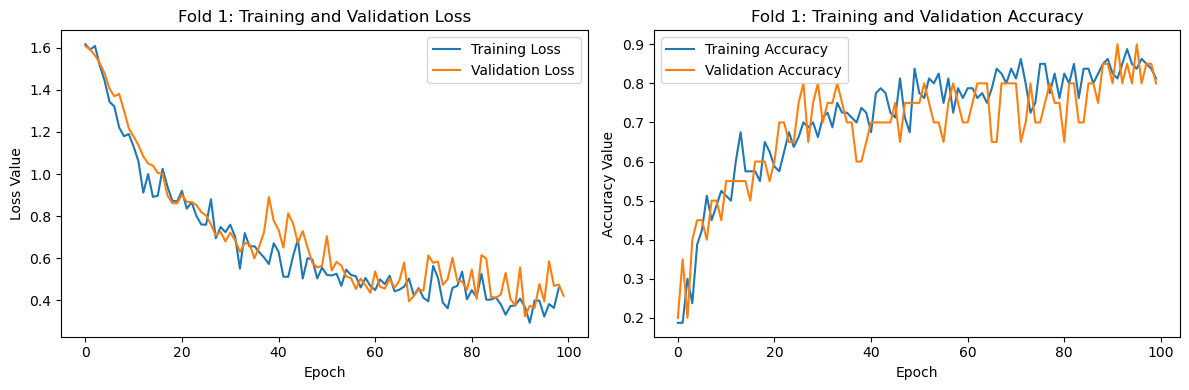

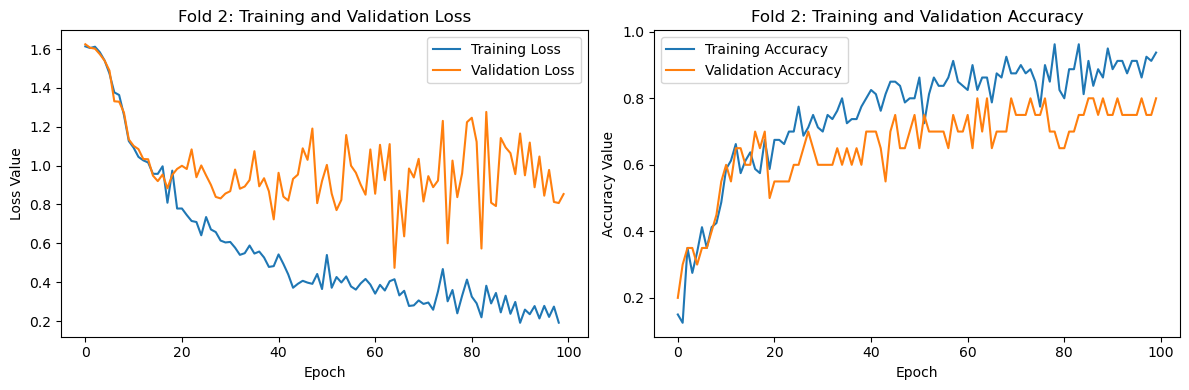

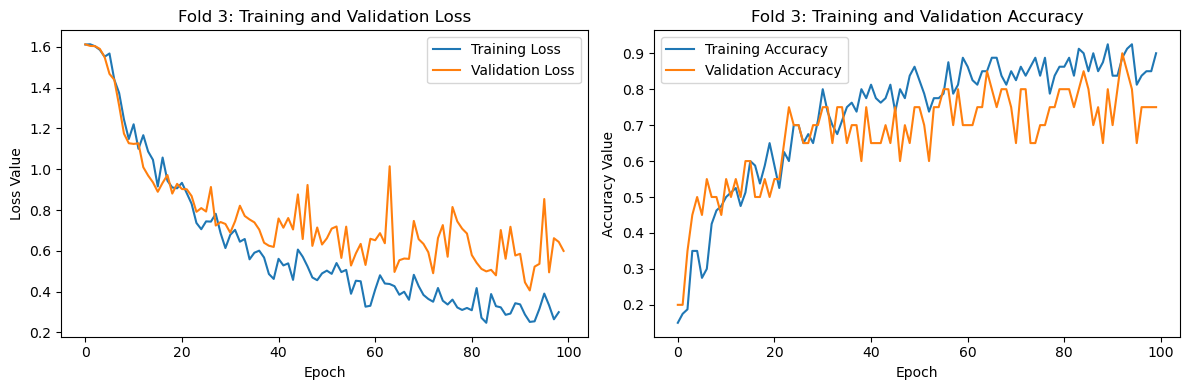

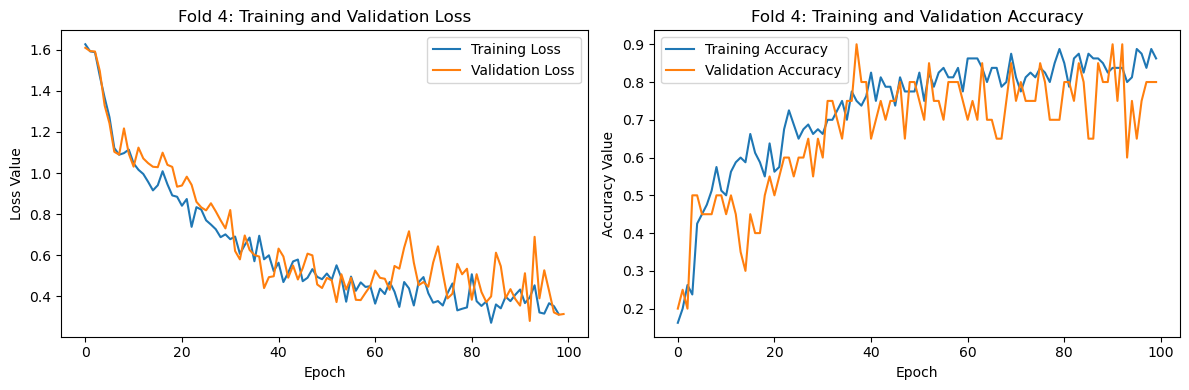

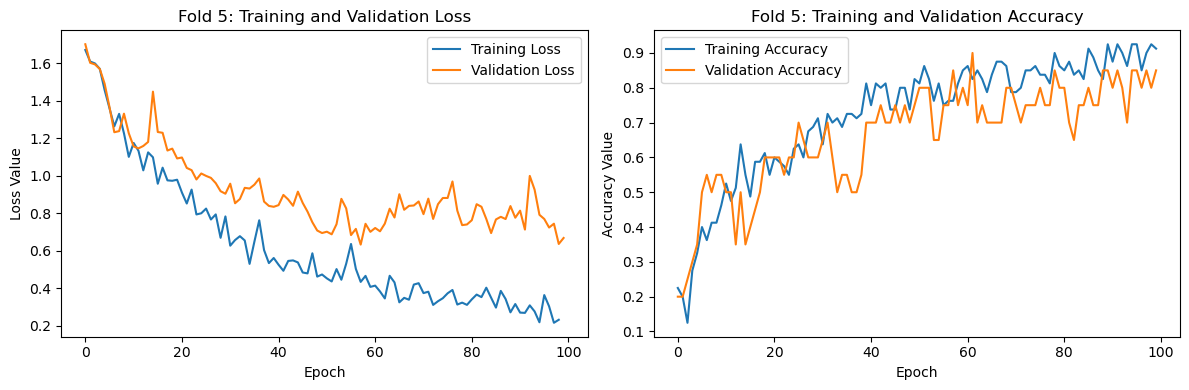

In [ ]:
# Inicialize um contador
fold_number = 1

for history in histories:
    
    # Plotar loss de treinamento e validação
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'][1:], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_number}: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()

    # Plotar accuracy de treinamento e validação
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold_number}: Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Value')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # Incrementar o contador
    fold_number += 1


In [ ]:
def plot_misclassified_images(X_val, y_true, y_pred, class_names, model_number):
    misclassified_indices = np.where(y_true != y_pred)[0]
    n = len(misclassified_indices)
    plt.suptitle("All images miss-classifieds", fontsize=24, y=1.02)  # Adiciona um título geral
    plt.figure(figsize=(20, 4 * ((n // 5) + 1)))

    for i, idx in enumerate(misclassified_indices):
        plt.subplot(n // 5 + 1, 5, i + 1)
        plt.imshow(X_val[idx], cmap="gray")
        plt.title(f"Model {model_number}\nTrue: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Inicialize um contador
model_number = 1

for model in models:
    class_names = list(label_dict.keys())
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Model {model_number}')
    plt.show()   

    plot_misclassified_images(X_val, y_true, y_pred, class_names, model_number)
    
    # Incrementar o contador
    model_number += 1



NameError: name 'models' is not defined

In [ ]:
# Data augmentation apenas no conjunto de treino
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_brightness_adjustment, 
    rotation_range=5,        # Rotação aleatória de até 5 graus
    width_shift_range=0.1,    # Deslocamento horizontal aleatório
    height_shift_range=0.05,   # Deslocamento vertical aleatório       
    horizontal_flip=False,     # Inverter aleatoriamente as imagens horizontalmente
    vertical_flip=False,
    fill_mode='nearest'       # Modo de preenchimento para áreas fora da imagem original
)


# Criando um gerador
train_generator_plot = train_datagen.flow(X, y, batch_size=100)


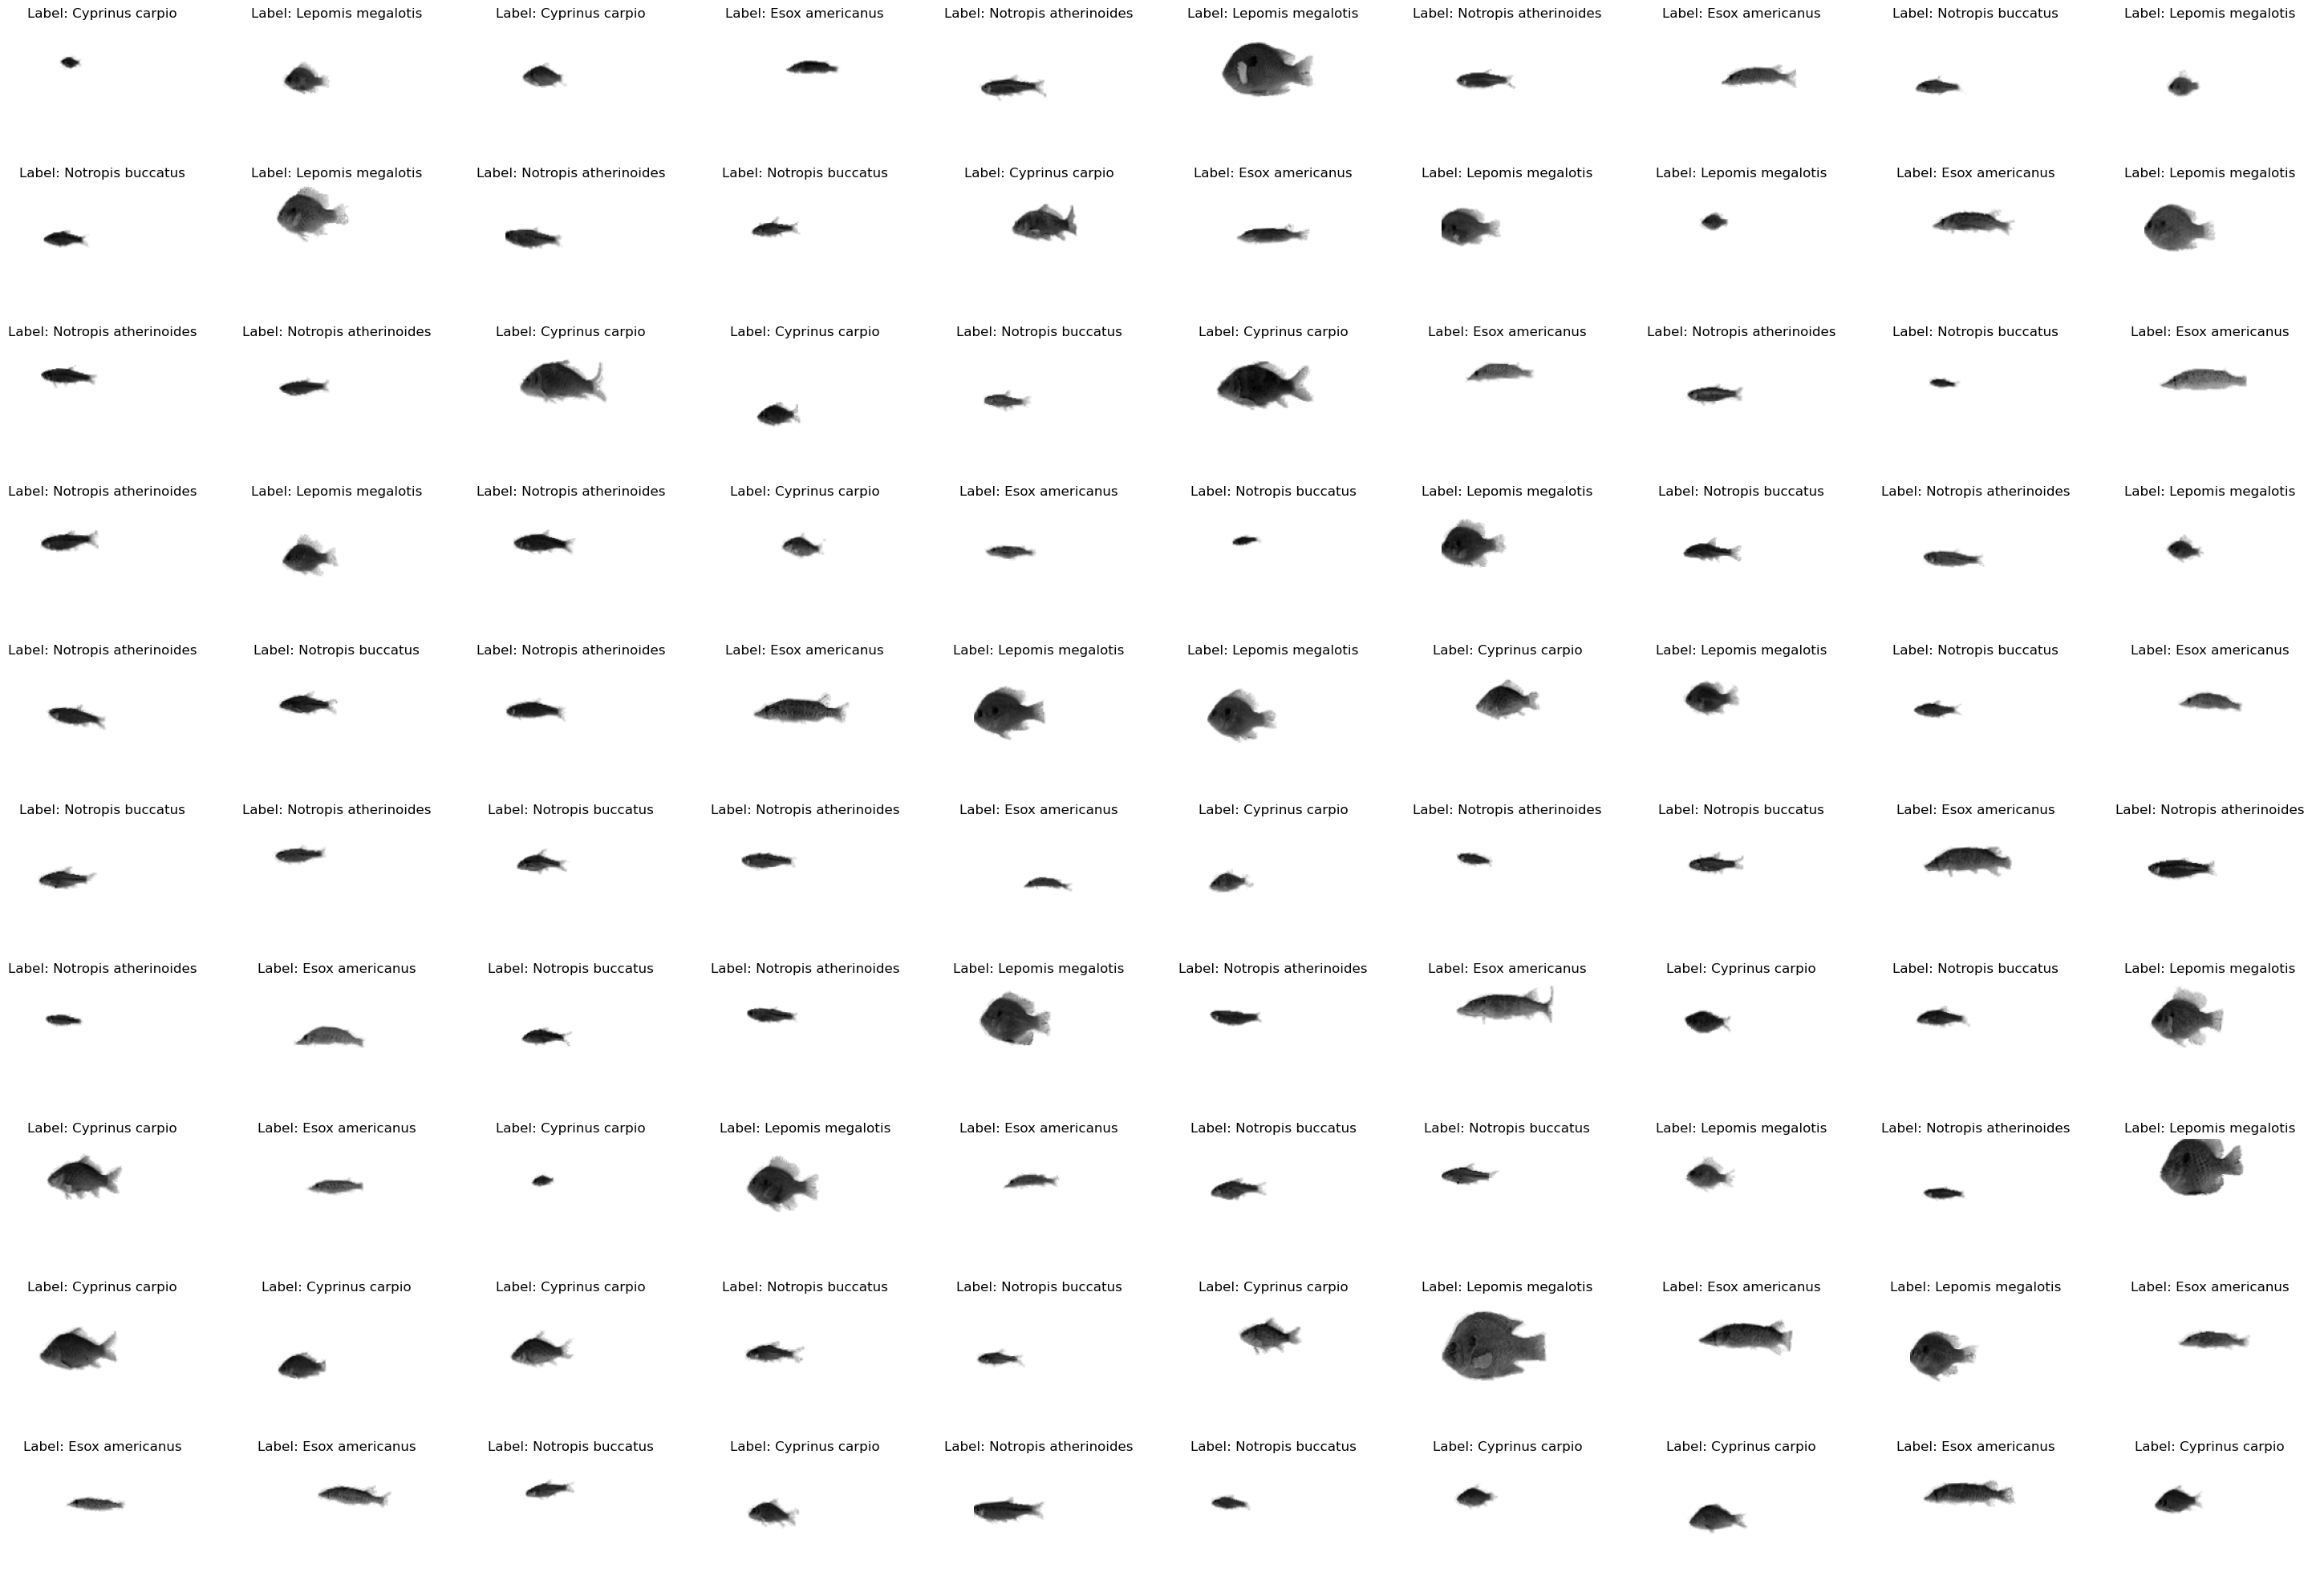

In [ ]:
def onehot_to_name(label, label_dict):
    # Encontra o índice do valor máximo (que será 1 em um vetor one-hot)
    index = np.argmax(label)
    # Usa o índice para encontrar o nome da espécie correspondente no dicionário
    for name, idx in label_dict.items():
        if idx == index:
            return name
import matplotlib.pyplot as plt

# Pegar um lote de imagens do augmented_data

total_images = 100
batch_size = 10
num_batches = total_images // batch_size

all_images = []
all_labels = []

for _ in range(num_batches):
    images, labels = next(train_generator_plot)
    all_images.extend(images)
    all_labels.extend(labels)

# Agora, all_images e all_labels contêm todas as imagens e rótulos de todos os batches

num_rows = 10
num_cols = 10
num_images_to_show = num_rows * num_cols

plt.figure(figsize=(30, 20))  # Ajuste o tamanho da figura conforme necessário
for i in range(num_images_to_show):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(all_images[i], cmap="gray")
    species_name = onehot_to_name(all_labels[i], label_dict)
    plt.title(f"Label: {species_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()
